# Ticket Triage Exploration Notebook - Week 3

The goal is to understand the data, and do a few experiments testing the use of LLMs for our eventual app

In [2]:
# Imports 

import pandas as pd # for dataframe handling, CSV reading, etc.
import requests     # for forming HTTP requests
import random       # random number generator
from openai import OpenAI
import os
from dotenv import load_dotenv


## Set up helper functions 

""" 
Helper functions
"""

def show_error(err_string: str):
    """
    Print an error message and stop execution
    """
    print(f"Error: {err_string}")
    SystemExit()


def load_data(csv_path: str):
    """
    Load support ticket data from a CSV file.
    
    This function reads a CSV file containing support tickets and returns it as a 
    pandas DataFrame (think of it as a table/spreadsheet in Python).
    
    Returns:
        pd.DataFrame: A table containing all the support tickets with columns like
                     subject, body, priority, language, etc.
        None: If the file can't be found or loaded
    
    Example CSV structure:
        subject        | body            | 
        ---------------|-----------------|
        Login issue    | Can't log in... | 
    """
    # Define the path to our CSV file (relative to where the script is run)
    
    try:
        # Try to read the CSV file into a DataFrame (table)
        df = pd.read_csv(csv_path)
        return df
    except FileNotFoundError:
        # If the file doesn't exist, show an error message to the user
        show_error(f"CSV file not found at {csv_path}")
        return None
    except Exception as e:
        # If any other error occurs, show the error details
        show_error(f"Error loading CSV: {str(e)}")
        return None
    
load_dotenv()  # reads .env in the current working directory to get the groq api key

# set the model we'll use in subsequent operations:
our_model = 'gpt-oss-20b'
# Point the SDK at LLM provider

# If we're using LM Studio locally:
_client = OpenAI(
    base_url="http://192.168.7.211:1234/v1",
    api_key="lm-studio"  # any non-empty string works for LM Studio
)

# or use this in to call a model on groq:

#_client = OpenAI(
#    base_url="https://api.groq.com/openai/v1",
#    api_key=os.environ["GROQ_API_KEY"],) # must have a GROQ_API_KEY in the .env file

def call_llm_sdk(      system_content: str,                   
                       user_content: str,                   
                       model: str = "gpt-oss-20b",
                       max_tokens: int = 2000,
                       temperature: float = 0.1,
                       reasoning_effort: str="low",
                       ) -> str:
    """
    Call LLM Provider via the OpenAI SDK (function call) instead of manual HTTP.

    Args:
        system_content: System prompt/instructions.
        user_content: User message.
        model: Model name exposed by provider - defaults to 'gpt-oss-20b', make sure the provider actually has this model or you'll get an error.
        max_tokens: Max tokens to generate - defaults to 1200 tokens; generation will stop when it hits this limit, so be sure to specify sufficent size to allow a response.
        temperature: Sampling temperature - defaults to 0.1 which is meant to be more 'deterministic' and less 'creative'.

    Returns:
        The assistant's reply text. Stops on errors. More sophisticated error handling would be smart!
    """
    try:
        resp = _client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            reasoning_effort=reasoning_effort,
        )
        return resp.choices[0].message.content
    except Exception as e:
        # keep your existing helper if you have it; otherwise raise
        try:
            show_error(f"Error calling LLM: {e}")
        except NameError:
            raise

""" 
Load the csv file into a pandas data frame
"""

csv_file = "../Week02/IT_Tickets/dataset-tickets-multi-lang_cleaned.csv"
df = load_data(csv_file)




# Let's simplify and standardize the output

- First, take all the bits we did last week + the homework and put it in a single chunk of code
- Second, take all the returns from the LLM calls and package them into a nice JSON object

In [3]:
# get a random ticket
ticket_number = random.randint(0, len(df))
# ========== DETECT LANGUAGE ==========
# Prepare prompts for language detection
system_prompt = "You are a helpful assistant analyzing support tickets."

# Create a detailed prompt asking the AI to detect the language
# The triple quotes (###) help the AI understand boundaries
user_prompt = \
f"""Analyze the following support request email and return ONLY the name of the language it is written in, 
return one of the following languages:
German; English; French; Portuguese; Spanish; Unknown;

###
Subject: {df.iloc[ticket_number]['subject']}

Body: {df.iloc[ticket_number]['body']}
###

Your response should be simply one of [German, English, French, Portuguese, Spanish or Unknown], with no additional commentary or charachters; 
If there is more than one language present, choose the predominent one.
"""

# Call the AI to detect language
# ai_response = call_lm_studio_requests(system_prompt, user_prompt)

ai_response = call_llm_sdk(system_prompt, user_prompt, model=our_model, max_tokens=1200, temperature=0.1)

# Clean up the response and extract just the language code

language_code = ai_response.strip().lower() if ai_response else "NO RESPONSE"


# use the ticket number from the previous cell so we can work through the ticket fields
# we will use language_code from the prior cell in this prompt to help the LLM do a nice translation.

# ========== Translate the Subject ==========
# Prepare prompts for Subject translation
system_prompt = "You are a helpful assistant whose assigned the job of translating support tickets from the original language to English."

# Create a detailed prompt asking the AI to detect the language
# The triple quotes (###) help the AI understand boundaries
user_prompt = \
f"""Translate the following email subject line from {language_code} to English, while adapting it to American idioms and phrasing - 
your translation should faithfully match the meaning of the original: 

###
{df.iloc[ticket_number]['subject']}
###

your response should be simply be the English translation with no other information."""
                    
 
# Call the AI to detect language
ai_response = call_llm_sdk(system_prompt, user_prompt, model=our_model, reasoning_effort='medium')

# Clean up the response and extract just the language code
subject = ai_response.strip() if ai_response else "NO SUBJECT"


# use the ticket number from the previous cell so we can work through the ticket fields
# we will use language_code from the prior cell in this prompt to help the LLM do a nice translation.

# ========== Translate the Email Body ==========
# Prepare prompts for Email Body translation
system_prompt = "You are a helpful assistant whose assigned the job of translating support tickets from the original language to English."

# Create a detailed prompt asking the AI to detect the language
# The triple quotes (###) help the AI understand boundaries
user_prompt = \
f"""Translate the following email body from {language_code} to English, while adapting it to American idioms and phrasing - 
your translation should faithfully match the meaning of the original: 

###
{df.iloc[ticket_number]['body']}
###

Your response should be simply be the English translation with no other information.
"""
                    
# Call the AI to detect language
ai_response = call_llm_sdk(system_prompt, user_prompt, model=our_model, reasoning_effort='medium')

# Clean up the response and extract just the language code
body = ai_response.strip() if ai_response else "NO BODY"

# Add a cell to classify tickets into 4 Types: Incident, Request, Change, Problem - you'll have to craft a prompt that explains to the LLM what thse mean (or maybe not - you can try just asking first)

# use the ticket number from the previous cell so we can work through the ticket fields

# ========== Use the translated Email Subject and Body ==========
# Prepare prompts for Email Body translation
system_prompt = "You are a helpful assistant whose assigned the job of classifying support tickets."

# Create a detailed prompt asking the AI to determine the category of the ticket
# The triple quotes (###) help the AI understand boundaries
user_prompt = \
f"""Cattegorize the following email into one of the following categories: Incident, Request, Change, or Problem: 

###
Subject: {subject}
Body: {body}
###

Your response should be simply be one of Incident, Request, Change, or Problem with no other information.
"""
                    
# Call the AI to determine the category
ai_response = call_llm_sdk(system_prompt, user_prompt, model=our_model, reasoning_effort='high')

# Clean up the response and extract just the category
category = ai_response.strip() if ai_response else "NO CATEGORY"

# Homework 2
# Add a cell to determine what departmental queue the ticket should be routed to: Billing & Payments, Customer Service, General Inquiry, Human Resources, 
# IT Support, Product Support, Returns and Exchanges, Sales and Pre-Sales, Service Outages, Technical Support
# Remember the concept of one-shot/multi-shot: You could craft a long prompt that gives an example of an email and assignment for each of these categories... 
# Examples are a GREAT way to show an LLM what you want.

# use the ticket number from the previous cell so we can work through the ticket fields
# ========== Use the translated Email Subject and Body ==========
# Prepare prompts for Email Body translation
system_prompt = "You are a helpful assistant whose assigned the job of routing support tickets to the correct department."

# Create a detailed prompt asking the AI to find the proper department to route the ticket to
# The triple quotes (###) help the AI understand boundaries
user_prompt = \
f"""Determine the correct department to route the following email. The available departments are:
Billing and Payments, Customer Service, General Inquiry, Human Resources, 
IT Support, Product Support, Returns and Exchanges, Sales and Pre-Sales, 
Service Outages and Maintenance, Technical Support. 

###
Subject: {subject}
Body: {body}
###

Your response should be simply be one of Billing and Payments, Customer Service, General Inquiry, Human Resources, 
IT Support, Product Support, Returns and Exchanges, Sales and Pre-Sales, 
Service Outages and Maintenance, Technical Support with no other information.
"""
                    
# Call the AI to determine the proper department to route to
ai_response = call_llm_sdk(system_prompt, user_prompt, model=our_model, reasoning_effort='high')

# Clean up the response and extract just the department
department = ai_response.strip() if ai_response else "NO DEPARTMENT"

# Add a cell to determine the priority of the ticket: P1, P2, P3 – read the rules for the priorities and use those rules in your 
# prompt to have the LLM assign the correct priority.
# Again, you can explain the priority levels to the LLM and/or you can provide examples in the prompt. 
# I sketched in the prioritization rules below from the slides

# use the ticket number from the previous cell so we can work through the ticket fields

# ========== Use the translated Email Subject and Body ==========
# Prepare prompts for Email Body translation
system_prompt = "You are a helpful assistant who is assigned the job of determining the priority of support tickets so they can be handled in the proper order."

# Create a detailed prompt asking the AI to determine the ticket's priority
# The triple quotes (###) help the AI understand boundaries
user_prompt = \
f"""Determine the correct prioritization for the ticket subject and body accoring to the rules below; the possible priorities are P1, P2 or P3:
Rules for Priority Assignment

P1 - Critical
Security or privacy incident: data breach, ransomware, malware outbreak, phishing success, compromised account, stolen device with sensitive data.
Payment/revenue blocking: checkout/payment API down, failed customer transactions at scale.
Company-wide or regional outage: SSO, VPN, email, network, authentication unavailable.
Safety/legal risk: regulatory or compliance breach, urgent legal exposure.
High impact blocking: department/region/companywide/external customers cannot work, and urgency is blocking or deadline today.

P2 - Major
Medium impact blocking or deadline: a team is blocked, or a single user is blocked with a hard deadline.
Degraded shared service: email delays, slow VPN, partial outage affecting multiple users.
Single user blocking: cannot log in, device will not boot, locked account (no explicit deadline).

P3 - Minor
Informational requests: “how do I…”, “please provide access,” feature requests.
Cosmetic issues, minor bugs, or general inquiries.
Non-blocking tickets with no deadline.

Tie-Breakers
If multiple rules match, select the highest priority (P1 > P2 > P3).
If signals conflict, assign the lower (safer) priority and reduce confidence.

###
Determine the priority of the following support request:

Subject: {subject}
Body: {body}
### 

Your response should be simply be one of P1, P2 or P2 according to the rules. 
"""
                    
# Call the AI to detect the priority
ai_response = call_llm_sdk(system_prompt, user_prompt, model=our_model, reasoning_effort='high')

# Clean up the response and extract just the priority code
priority = ai_response.strip() if ai_response else "NO PRIORITY"

# Add a ”final output” that wraps all of the fields (translated subject, translated body, incident type, queue and priority) 
# and readies it to send on to the appropriate queue... 
# If your primary language is not English, try having the LLM translate this final bundle into your language.  
# How was the quality of the translation?  
# If the model isn’t doing a great job, search for a model that’s more tuned for your language (it would also have to know the source languages of course).   

import json                                                                                                    

# Create a dictionary with the ticket information                                                              
ticket_data = {                                                                                               
  "ticket": ticket_number,                                                                               
  "language": language_code,                                                                             
  "subject": subject,                                                                                     
  "email_body": body,                                                                                      
  "category": category,                                                                                   
  "queue": department,                                                                                     
  "priority": priority                                                                                     
}                                                                                                             

# Convert to JSON string with nice formatting                                                                  
json_output = json.dumps(ticket_data, indent=2, ensure_ascii=False)                                          

# Print the formatted JSON                                                                                
print(json_output)                                                                                       

{
  "ticket": 1676,
  "language": "french",
  "subject": "Urgent: PostgreSQL Database Connection Issue",
  "email_body": "Dear Support Team,\n\nI’m encountering a critical issue in our application involving a connection error to the PostgreSQL database. This is severely impacting functionality. The problem pertains to our product, MySQL 8.0.30. Immediate troubleshooting and resolution are required—please advise on next steps.\n\nThank you.  \n<name>",
  "category": "Incident",
  "queue": "Technical Support",
  "priority": "P1"
}


## That's cool but maybe we can get the LLM to do a lot of this for us...

# Let's go further and combine all the LLM calls into a single call...

- Take all of the prompts and rewrite into a single prompt so the LLM can turn it around in one go...
- We'll ask for the return to be structured as JSON so we don't have to build it ourselves!
- Instead of 6 LLM calls and a "packaging" of the responses at the end, we'll have a single LLM call that does it all.

In [5]:
# let's create a ticket handling function that takes in the ticket subject and body and returns a JSON object with all the details, and do it in one prompt.

def call_llm_sdk(      system_content: str,                   
                       user_content: str,                   
                       model: str = "gpt-oss-20b",
                       max_tokens: int = 2000,
                       temperature: float = 0.1,
                       reasoning_effort: str="low",
                       ) -> str:
    """
    Call LLM Provider via the OpenAI SDK (function call) instead of manual HTTP.

    Args:
        system_content: System prompt/instructions.
        user_content: User message.
        model: Model name exposed by provider - defaults to 'gpt-oss-20b', make sure the provider actually has this model or you'll get an error.
        max_tokens: Max tokens to generate - defaults to 1200 tokens; generation will stop when it hits this limit, so be sure to specify sufficent size to allow a response.
        temperature: Sampling temperature - defaults to 0.1 which is meant to be more 'deterministic' and less 'creative'.

    Returns:
        The assistant's reply text. Stops on errors. More sophisticated error handling would be smart!
    """
    try:
        resp = _client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            reasoning_effort=reasoning_effort,
        )
        return resp.choices[0].message.content
    except Exception as e:
        # keep your existing helper if you have it; otherwise raise
        try:
            show_error(f"Error calling LLM: {e}")
        except NameError:
            raise

def process_ticket(ticket_number: int, ticket_subject: str, ticket_body: str, model: str):
    # ========== CONSOLIDATED TICKET ANALYSIS ==========
    # Prepare prompts for comprehensive ticket analysis
    system_prompt = "You are a helpful assistant that analyzes and processes support tickets. You must return your response as a valid JSON object with no additional text or commentary."

    # Create a comprehensive prompt that handles all analysis tasks
    user_prompt = f"""Analyze the following support request email and return a JSON object with the specified fields. Follow the rules exactly as provided.

    ###
    Subject: {ticket_subject}
    Body: {ticket_body}
    ###

    Please analyze this ticket and return a JSON object with the following structure:
    {{
    "ticket": {ticket_number},
    "language": "language_name",
    "subject": "translated_subject",
    "email_body": "translated_body", 
    "category": "ticket_category",
    "queue": "department_name",
    "priority": "priority_level"
    }}

    INSTRUCTIONS FOR EACH FIELD:

    1. LANGUAGE: Detect the primary language and return one of: German, English, French, Portuguese, Spanish, Unknown

    2. SUBJECT: Translate the subject line to English using American idioms and phrasing. If already in English, return as-is but ensure proper American phrasing.

    3. EMAIL_BODY: Translate the email body to English using American idioms and phrasing. If already in English, return as-is but ensure proper American phrasing.

    4. CATEGORY: Classify the ticket into one of: Incident, Request, Change, Problem

    5. QUEUE: Route to the correct department from: Billing & Payments, Customer Service, General Inquiry, Human Resources, IT Support, Product Support, Returns and Exchanges, Sales and Pre-Sales, Service Outages, Technical Support

    6. PRIORITY: Assign priority according to these rules:

    P1 - Critical:
    - Security/privacy incident (data breach, ransomware, malware, phishing, compromised account, stolen device)
    - Payment/revenue blocking (checkout/payment API down, failed transactions at scale)
    - Company-wide or regional outage (SSO, VPN, email, network, authentication unavailable)
    - Safety/legal risk (regulatory/compliance breach, urgent legal exposure)
    - High impact blocking (department/region/company-wide/external customers cannot work, deadline today)

    P2 - Major:
    - Medium impact blocking or deadline (team blocked, single user blocked with hard deadline)
    - Degraded shared service (email delays, slow VPN, partial outage affecting multiple users)
    - Single user blocking (cannot log in, device won't boot, locked account, no explicit deadline)

    P3 - Minor:
    - Informational requests ("how do I...", "please provide access", feature requests)
    - Cosmetic issues, minor bugs, general inquiries
    - Non-blocking tickets with no deadline

    Tie-Breakers: If multiple rules match, select highest priority (P1 > P2 > P3). If signals conflict, assign lower (safer) priority.

    Return ONLY the JSON object with no additional text, explanations, or formatting."""

    # Call the AI for comprehensive analysis
    ai_response = call_llm_sdk(system_prompt, user_prompt, model=model, max_tokens=4000, temperature=0.1, reasoning_effort="low")

    # Parse the JSON response
    try:
        import json
        ticket_data = json.loads(ai_response.strip())
        
        # return the formatted JSON
        return ticket_data
        
    except json.JSONDecodeError as e:
       
        # Fallback: create manual structure if JSON parsing fails - include the ai_response for debugging
        ticket_data = {
            "ticket": ticket_number,
            "language": "Error",
            "subject": "Error",
            "email_body": "Error", 
            "category": "Error",
            "queue": "Error",
            "priority": "Error",
            "raw response": "\"" + f"{ai_response}" + "\""
        }
        return ticket_data

# Try our new function first with gpt-oss-20b

In [6]:
tik_no = 111
our_model = 'gpt-oss-20b'
resp = process_ticket(tik_no, df.iloc[tik_no]['subject'], df.iloc[tik_no]['body'], model=our_model)
print(json.dumps(resp, indent=2, ensure_ascii=False))

{
  "ticket": 111,
  "language": "Portuguese",
  "subject": "Request for Cost-Effective AWS Management Solutions",
  "email_body": "Dear Customer Support Team,\n\nI hope this message finds you well. My name is <name> and I am currently overseeing operations at the <name> office. We have been using your AWS Management Services for the past year, and while the service has been satisfactory, we have encountered some challenges related to the high operational costs associated with it.\n\nIn light of these financial constraints, we are seeking advice on how best to optimize our existing AWS Management Services. Specifically, we are interested in exploring cost‑effective solutions that can help streamline our operations without compromising performance or reliability. Could you please provide insights or recommendations on options or adjustments available for us to consider?\n\nUnderstanding the details of our AWS usage and identifying potential areas for cost savings could greatly benefit o

# Works great!
- Perfect JSON format
- All we had to do was ask nicely!

# Now try with a different model; nvidia's nemotron nano 9b


In [7]:
tik_no = 111
our_model = 'nvidia_nvidia-nemotron-nano-9b-v2'
resp = process_ticket(tik_no, df.iloc[tik_no]['subject'], df.iloc[tik_no]['body'], model=our_model)
print(json.dumps(resp, indent=2, ensure_ascii=False))

{
  "ticket": 111,
  "language": "Error",
  "subject": "Error",
  "email_body": "Error",
  "category": "Error",
  "queue": "Error",
  "priority": "Error",
  "raw response": "\"<think>\nOkay, let's tackle this query. The user wants me to analyze a support ticket email and return a JSON object with specific fields. First, I need to make sure I understand all the requirements.\n\nThe email is in Portuguese. So for the \"language\" field, it should be Portuguese. Next, translating the subject line to English using American idioms. The original subject is \"Solicitação de Soluções de Gerenciamento da AWS Eficientes em Custo\". Translating that, maybe something like \"Request for Cost-Effective AWS Management Solutions\".\n\nThe email body needs translation too. The user mentions high operational costs with AWS services and wants cost optimization without compromising performance or reliability. So the translated body should convey that they're looking for advice on optimizing their existing

# Uh oh... not so good.
- Many models are not very good at following instructions with regard to structured output
- Sometimes this is noted on the HF Model card... sometimes you just have to try it.

# We can help those models out by supplying a specific schema in the SDK Call
- use the 'response_format' parameter 
- provide a schema template

In [8]:
# let's create a NEW ticket handling function that takes in the ticket subject and body and returns a JSON object with all the details, and do it in one prompt AND use a response_format schema

def call_llm_sdk_with_schema(      system_content: str,                   
                       user_content: str,                   
                       model: str = "gpt-oss-20b",
                       max_tokens: int = 2000,
                       temperature: float = 0.1,
                       reasoning_effort: str="low",
                       schema_template: str="",
                       ) -> str:
    """
    Call LLM Provider via the OpenAI SDK (function call) instead of manual HTTP.

    Args:
        system_content: System prompt/instructions.
        user_content: User message.
        model: Model name exposed by provider - defaults to 'gpt-oss-20b', make sure the provider actually has this model or you'll get an error.
        max_tokens: Max tokens to generate - defaults to 1200 tokens; generation will stop when it hits this limit, so be sure to specify sufficent size to allow a response.
        temperature: Sampling temperature - defaults to 0.1 which is meant to be more 'deterministic' and less 'creative'.

    Returns:
        The assistant's reply text. Stops on errors. More sophisticated error handling would be smart!
    """
    try:
        resp = _client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            reasoning_effort=reasoning_effort,
            response_format=schema_template,
        )
        return resp.choices[0].message.content
    except Exception as e:
        # keep your existing helper if you have it; otherwise raise
        try:
            show_error(f"Error calling LLM: {e}")
        except NameError:
            raise

def process_ticket_with_schema(ticket_number: int, ticket_subject: str, ticket_body: str, model: str, schema_template: str):
    # ========== CONSOLIDATED TICKET ANALYSIS ==========
    # Prepare prompts for comprehensive ticket analysis
    system_prompt = "You are a helpful assistant that analyzes and processes support tickets. You must return your response as a valid JSON object with no additional text or commentary."

    # Create a comprehensive prompt that handles all analysis tasks
    user_prompt = f"""Analyze the following support request email and return a JSON object with the specified fields. Follow the rules exactly as provided.

    ###
    Subject: {ticket_subject}
    Body: {ticket_body}
    ###

    Please analyze this ticket and return a JSON object with the following structure:
    {{
    "ticket": {ticket_number},
    "language": "language_name",
    "subject": "translated_subject",
    "email_body": "translated_body", 
    "category": "ticket_category",
    "queue": "department_name",
    "priority": "priority_level"
    }}

    INSTRUCTIONS FOR EACH FIELD:

    1. LANGUAGE: Detect the primary language and return one of: German, English, French, Portuguese, Spanish, Unknown

    2. SUBJECT: Translate the subject line to English using American idioms and phrasing. If already in English, return as-is but ensure proper American phrasing.

    3. EMAIL_BODY: Translate the email body to English using American idioms and phrasing. If already in English, return as-is but ensure proper American phrasing.

    4. CATEGORY: Classify the ticket into one of: Incident, Request, Change, Problem

    5. QUEUE: Route to the correct department from: Billing and Payments, Customer Service, General Inquiry, Human Resources, IT Support, Product Support, Returns and Exchanges, Sales and Pre-Sales, Service Outages and Maintenance, Technical Support

    6. PRIORITY: Assign priority according to these rules:

    P1 - Critical:
    - Security/privacy incident (data breach, ransomware, malware, phishing, compromised account, stolen device)
    - Payment/revenue blocking (checkout/payment API down, failed transactions at scale)
    - Company-wide or regional outage (SSO, VPN, email, network, authentication unavailable)
    - Safety/legal risk (regulatory/compliance breach, urgent legal exposure)
    - High impact blocking (department/region/company-wide/external customers cannot work, deadline today)

    P2 - Major:
    - Medium impact blocking or deadline (team blocked, single user blocked with hard deadline)
    - Degraded shared service (email delays, slow VPN, partial outage affecting multiple users)
    - Single user blocking (cannot log in, device won't boot, locked account, no explicit deadline)

    P3 - Minor:
    - Informational requests ("how do I...", "please provide access", feature requests)
    - Cosmetic issues, minor bugs, general inquiries
    - Non-blocking tickets with no deadline

    Tie-Breakers: If multiple rules match, select highest priority (P1 > P2 > P3). If signals conflict, assign lower (safer) priority.

    Return ONLY the JSON object with no additional text, explanations, or formatting."""

    # Call the AI for comprehensive analysis
    ai_response = call_llm_sdk_with_schema(system_prompt, user_prompt, model=model, max_tokens=4000, temperature=0.1, reasoning_effort="low", schema_template=schema_template)

    # Parse the JSON response
    try:
        import json
        ticket_data = json.loads(ai_response.strip())
        
        # return the formatted JSON
        return ticket_data
        
    except json.JSONDecodeError as e:
       
        # Fallback: create manual structure if JSON parsing fails - include the ai_response for debugging
        ticket_data = {
            "ticket": ticket_number,
            "language": "Error",
            "subject": "Error",
            "email_body": "Error", 
            "category": "Error",
            "queue": "Error",
            "priority": "Error",
            "raw response": "\"" + f"{ai_response}" + "\""
        }
        return ticket_data

# Let's try again with our schema_template being sent along...

In [9]:
# Define the expected response structure for ticket analysis
ticket_schema = {
    "type": "json_schema",
    "json_schema": {
        "name": "ticket_analysis",
        "schema": {
            "type": "object",
            "additionalProperties": False,
            "properties": {
                "ticket": { "oneOf": [ { "type": "integer" }, { "type": "string" } ] },
                "language": { "type": "string" },
                "subject": { "type": "string" },
                "email_body": { "type": "string" },
                "category": { "type": "string" },
                "queue": { "type": "string" },
                "priority": { "type": "string" }
            },
            "required": [
                "ticket",
                "language",
                "subject",
                "email_body",
                "category",
                "queue",
                "priority"
            ]
        }
    }
}


In [10]:
tik_no = 111
our_model = 'nvidia_nvidia-nemotron-nano-9b-v2'
resp = process_ticket_with_schema(tik_no, df.iloc[tik_no]['subject'], df.iloc[tik_no]['body'], model=our_model, schema_template=ticket_schema)
print(json.dumps(resp, indent=2, ensure_ascii=False))

{
  "ticket": 111,
  "language": "Portuguese",
  "subject": "Request for Efficient AWS Management Solutions",
  "email_body": "Dear Customer Support Team,\n\nI hope this message finds you well. My name is <name> and I am currently overseeing operations at the <name> office. We have been utilizing your AWS Management Services for the past year, and while the service has been satisfactory, we have encountered some challenges related to high operational costs.\n\nGiven these financial constraints, we are seeking advice on how to best optimize our existing AWS Management Services. Specifically, we are interested in exploring cost-effective solutions that can help streamline our operations without compromising performance or reliability. Could you please provide insights or recommendations on available options or adjustments we could consider?\n\nUnderstanding the details of our AWS usage and identifying potential areas for cost savings would greatly benefit our financial planning and opera

# Perfect, nemotron now provides JSON formatted output!

# Next fun feature - Token tracking
- If we're using big frontier models in the cloud we typically pay per token when using API calls
- Right now we don't have a good sense of how many tokens each ticket processing consumes
- Different prices for Prompts and Output tokens typically

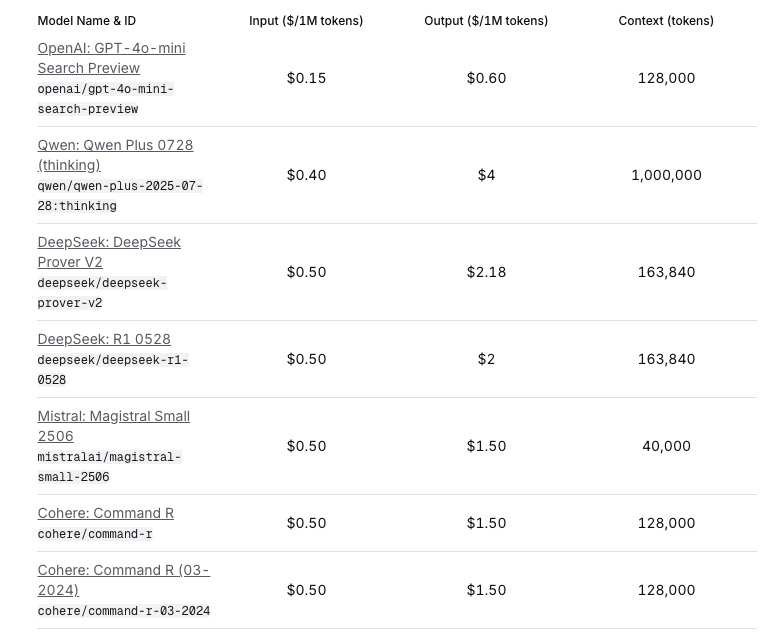

You'll want to look also at Rate/Request limits for providers - here's a sample of Groq's free models, and the restrictions on use:
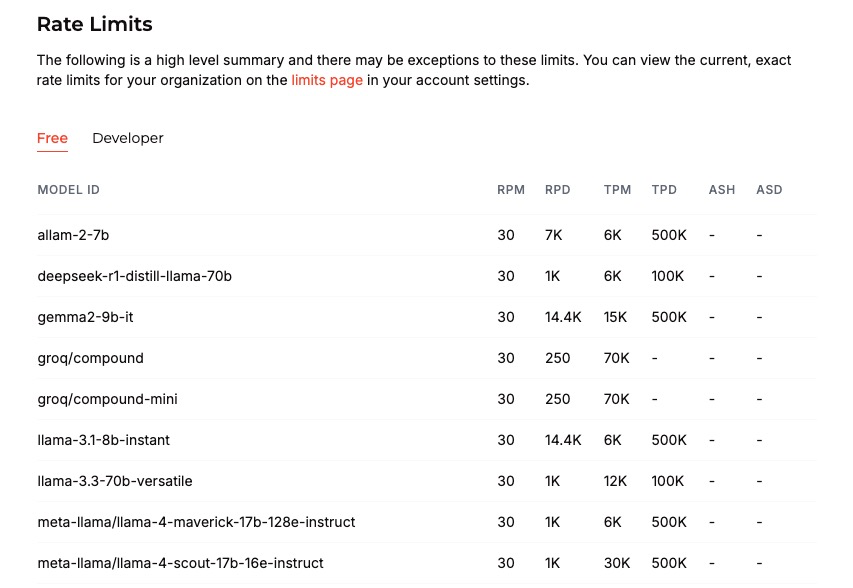

# So, we want to test how many tokens we're consuming so we understand how much it may cost us to process these tickets


In [12]:
# Updated version that returns token usage along with the response
def call_llm_sdk_with_tokens(system_content: str,
                             user_content: str,
                             model: str = "gpt-oss-20b",
                             max_tokens: int = 4000,
                             temperature: float = 0.1,
                             reasoning_effort: str = "low",
                             schema_template = None) -> tuple:
    """
    Call LLM Provider via the OpenAI SDK and return both response and token usage.
    
    Args:
        system_content: System prompt/instructions.
        user_content: User message.
        model: Model name exposed by provider.
        max_tokens: Max tokens to generate.
        temperature: Sampling temperature.
        reasoning_effort: Reasoning effort level.
        response_format: Optional response format schema.
    
    Returns:
        A tuple of (content, prompt_tokens, completion_tokens, total_tokens)
    """
    try:
        kwargs = {
            "model": model,
            "messages": [
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content},
            ],
            "max_tokens": max_tokens,
            "temperature": temperature,
        }
        
        # Add optional parameters if they exist
        if hasattr(_client.chat.completions, 'reasoning_effort'):
            kwargs["reasoning_effort"] = reasoning_effort
        if schema_template is not None:
            kwargs["response_format"] = schema_template
            
        resp = _client.chat.completions.create(**kwargs)
        
        # Extract token usage
        prompt_tokens = resp.usage.prompt_tokens if resp.usage else 0
        completion_tokens = resp.usage.completion_tokens if resp.usage else 0
        total_tokens = resp.usage.total_tokens if resp.usage else 0
        
        return (resp.choices[0].message.content, 
                prompt_tokens, 
                completion_tokens, 
                total_tokens)
    except Exception as e:
        print(f"Error calling LLM: {e}")
        return (None, 0, 0, 0)


# Updated process_ticket function that tracks token usage
def process_ticket_with_tokens(ticket_number: int, ticket_subject: str, ticket_body: str, model: str, schema_template=None):
    """Process a ticket and return both results and token usage."""
    # ========== CONSOLIDATED TICKET ANALYSIS ==========
    system_prompt = "You are a helpful assistant that analyzes and processes support tickets. You must return your response as a valid JSON object with no additional text or commentary."

    user_prompt = f"""Analyze the following support request email and return a JSON object with the specified fields. Follow the rules exactly as provided.

    ###
    Subject: {ticket_subject}
    Body: {ticket_body}
    ###

    Please analyze this ticket and return a JSON object with the following structure:
    {{
    "ticket": {ticket_number},
    "language": "language_name",
    "subject": "translated_subject",
    "email_body": "translated_body", 
    "category": "ticket_category",
    "queue": "department_name",
    "priority": "priority_level"
    }}

    INSTRUCTIONS FOR EACH FIELD:

    1. LANGUAGE: Detect the primary language and return one of: German, English, French, Portuguese, Spanish, Unknown

    2. SUBJECT: Translate the subject line to English using American idioms and phrasing. If already in English, return as-is but ensure proper American phrasing.

    3. EMAIL_BODY: Translate the email body to English using American idioms and phrasing. If already in English, return as-is but ensure proper American phrasing.

    4. CATEGORY: Classify the ticket into one of: Incident, Request, Change, Problem

    5. QUEUE: Route to the correct department from: Billing and Payments, Customer Service, General Inquiry, Human Resources, IT Support, Product Support, Returns and Exchanges, Sales and Pre-Sales, Service Outages and Maintenance, Technical Support

    6. PRIORITY: Assign priority according to these rules:

    P1 - Critical:
    - Security/privacy incident (data breach, ransomware, malware, phishing, compromised account, stolen device)
    - Payment/revenue blocking (checkout/payment API down, failed transactions at scale)
    - Company-wide or regional outage (SSO, VPN, email, network, authentication unavailable)
    - Safety/legal risk (regulatory/compliance breach, urgent legal exposure)
    - High impact blocking (department/region/company-wide/external customers cannot work, deadline today)

    P2 - Major:
    - Medium impact blocking or deadline (team blocked, single user blocked with hard deadline)
    - Degraded shared service (email delays, slow VPN, partial outage affecting multiple users)
    - Single user blocking (cannot log in, device won't boot, locked account, no explicit deadline)

    P3 - Minor:
    - Informational requests ("how do I...", "please provide access", feature requests)
    - Cosmetic issues, minor bugs, general inquiries
    - Non-blocking tickets with no deadline

    Tie-Breakers: If multiple rules match, select highest priority (P1 > P2 > P3). If signals conflict, assign lower (safer) priority.

    Return ONLY the JSON object with no additional text, explanations, or formatting."""

    # Call the AI for comprehensive analysis with token tracking
    ai_response, prompt_tokens, completion_tokens, total_tokens = call_llm_sdk_with_tokens(
        system_prompt, user_prompt, model=model, max_tokens=4000, 
        temperature=0.1, reasoning_effort="low", schema_template=schema_template
    )

    # Parse the JSON response
    try:
        import json
        if ai_response:
            ticket_data = json.loads(ai_response.strip())
            # Add token usage to the response
            ticket_data["token_usage"] = {
                "prompt_tokens": prompt_tokens,
                "completion_tokens": completion_tokens,
                "total_tokens": total_tokens
            }
        else:
            # Fallback if response is None
            ticket_data = {
                "ticket": ticket_number,
                "language": "Error",
                "subject": "Error",
                "email_body": "Error", 
                "category": "Error",
                "queue": "Error",
                "priority": "Error",
                "error": "No response from LLM",
                "token_usage": {
                    "prompt_tokens": prompt_tokens,
                    "completion_tokens": completion_tokens,
                    "total_tokens": total_tokens
                }
            }
        return ticket_data
        
    except json.JSONDecodeError as e:
        # Fallback if JSON parsing fails
        ticket_data = {
            "ticket": ticket_number,
            "language": "Error",
            "subject": "Error",
            "email_body": "Error", 
            "category": "Error",
            "queue": "Error",
            "priority": "Error",
            "error": f"JSON parsing error: {str(e)}",
            "raw_response": ai_response[:500] if ai_response else "None",
            "token_usage": {
                "prompt_tokens": prompt_tokens,
                "completion_tokens": completion_tokens,
                "total_tokens": total_tokens
            }
        }
        return ticket_data

In [13]:
# if we want to use Groq:
our_model="llama-3.1-8b-instant"
_client = OpenAI(
    base_url="https://api.groq.com/openai/v1",
    api_key=os.environ["GROQ_API_KEY"],
) # must have a GROQ_API_KEY in the .env file


In [14]:
# If we're using LM Studio locally:
our_model="qwen/qwen3-4b-2507"

_client = OpenAI(
    base_url="http://192.168.7.211:1234/v1",
    api_key="lm-studio"  # any non-empty string works for LM Studio
)

In [15]:
# Example: Process tickets with progress bar and token tracking
from tqdm import tqdm
import json

# Initialize token tracking
total_prompt_tokens = 0
total_completion_tokens = 0
total_all_tokens = 0

# Process a subset of tickets to demonstrate
num_tickets_to_process = 5  # Process just 5 tickets as an example
results = []

for tik_no, ticket in enumerate(tqdm(df.head(num_tickets_to_process).itertuples(), 
                                     total=num_tickets_to_process, 
                                     desc=f"Processing {num_tickets_to_process} tickets"), 
                                start=1):
    # Process ticket with token tracking
    resp = process_ticket_with_tokens(tik_no, ticket.subject, ticket.body, model=our_model)
    
    # Accumulate token usage
    if "token_usage" in resp:
        total_prompt_tokens += resp["token_usage"]["prompt_tokens"]
        total_completion_tokens += resp["token_usage"]["completion_tokens"]
        total_all_tokens += resp["token_usage"]["total_tokens"]
    
    results.append(resp)
    
    # Update progress bar with token info
#    tqdm.write(f"Ticket {tik_no}: {resp['token_usage']['total_tokens']} tokens used")

# Print summary
print(f"\n=== Token Usage Summary ===")
print(f"Total Prompt Tokens: {total_prompt_tokens:,}")
print(f"Total Completion Tokens: {total_completion_tokens:,}")
print(f"Total Tokens: {total_all_tokens:,}")
print(f"Average Tokens per Ticket: {total_all_tokens/num_tickets_to_process:,.0f}")

# Display first result as example
print(f"\n=== Example Result ===")
print(json.dumps(results[0], indent=2))

Processing 5 tickets: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


=== Token Usage Summary ===
Total Prompt Tokens: 3,958
Total Completion Tokens: 915
Total Tokens: 4,873
Average Tokens per Ticket: 975

=== Example Result ===
{
  "ticket": 1,
  "language": "Spanish",
  "subject": "Critical server issue requires immediate attention",
  "email_body": "An immediate investigation is needed into the disruption of the AWS management service, which is impacting essential commercial functions.",
  "category": "Incident",
  "queue": "IT Support",
  "priority": "P1",
  "token_usage": {
    "prompt_tokens": 655,
    "completion_tokens": 80,
    "total_tokens": 735
  }
}


# Week 3 - Homework 1

Run the process using the model and provider of your choice - make sure the JSON is returning correctly.  DO it for a sample, say the first 100 tickets.
    
For each returning JSON package add all the columns to an output data frame (include the initial subject and body in the original language)



In [18]:
# consolidate our various functions here:
# Updated version that returns token usage along with the response

# implemented some terminolgy fixes (eg. Px to high, medium, low - some '&' replaced with 'and' etc.)
def call_llm_sdk_with_tokens(system_content: str,
                             user_content: str,
                             model: str = "gpt-oss-20b",
                             max_tokens: int = 4000,
                             temperature: float = 0.1,
                             reasoning_effort: str = "low",
                             schema_template = None) -> tuple:
    """
    Call LLM Provider via the OpenAI SDK and return both response and token usage.
    
    Args:
        system_content: System prompt/instructions.
        user_content: User message.
        model: Model name exposed by provider.
        max_tokens: Max tokens to generate.
        temperature: Sampling temperature.
        reasoning_effort: Reasoning effort level.
        response_format: Optional response format schema.
    
    Returns:
        A tuple of (content, prompt_tokens, completion_tokens, total_tokens)
    """
    try:
        kwargs = {
            "model": model,
            "messages": [
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content},
            ],
            "max_tokens": max_tokens,
            "temperature": temperature,
        }
        
        # Add optional parameters if they exist
        if hasattr(_client.chat.completions, 'reasoning_effort'):
            kwargs["reasoning_effort"] = reasoning_effort
        if schema_template is not None:
            kwargs["response_format"] = schema_template
            
        resp = _client.chat.completions.create(**kwargs)
        
        # Extract token usage
        prompt_tokens = resp.usage.prompt_tokens if resp.usage else 0
        completion_tokens = resp.usage.completion_tokens if resp.usage else 0
        total_tokens = resp.usage.total_tokens if resp.usage else 0
        
        return (resp.choices[0].message.content, 
                prompt_tokens, 
                completion_tokens, 
                total_tokens)
    except Exception as e:
        print(f"Error calling LLM: {e}")
        return (None, 0, 0, 0)


# Updated process_ticket function that tracks token usage
def process_ticket_with_tokens(ticket_number: int, ticket_subject: str, ticket_body: str, model: str, schema_template=None):
    """Process a ticket and return both results and token usage."""
    # ========== CONSOLIDATED TICKET ANALYSIS ==========
    system_prompt = "You are an expert support ticket classifier with deep knowledge of IT service management. You must analyze support tickets and return precise classifications as a valid JSON object with no additional text."

    user_prompt = f"""Analyze this support ticket and classify it into the specified fields. Use the email content, context clues, and business patterns to make accurate predictions.

    ###
    Subject: {ticket_subject}
    Body: {ticket_body}
    ###

    Return a JSON object with this exact structure:
    {{
        "llm_ticket": {ticket_number},
        "llm_language": "detected_language",
        "llm_subject": "translated_subject", 
        "llm_email_body": "translated_body",
        "llm_type": "ticket_type",
        "llm_queue": "department_queue", 
        "llm_priority": "priority_level",
        "llm_business_type": "business_category",
        "llm_confidence": {{
            "language": confidence_score,
            "type": confidence_score,
            "queue": confidence_score,
            "priority": confidence_score,
            "business_type": confidence_score
        }}
    }}

    CLASSIFICATION RULES:

    **LANGUAGE**: Detect from text and return exactly one of:
    - "en" (English)
    - "es" (Spanish) 
    - "fr" (French)
    - "de" (German)
    - "pt" (Portuguese)

    **SUBJECT/EMAIL_BODY**: Translate to clear American English. If already English, improve clarity while preserving technical terms.

    **TYPE**: Use this DECISION TREE (check in exact order):

    STEP 1: Is something CURRENTLY broken, failed, or not working RIGHT NOW?
    - YES → Check: Is it a recurring pattern affecting multiple users/times?
    - YES → "Problem" 
    - NO → "Incident"
    - NO → Go to STEP 2

    STEP 2: Is user asking for help, access, information, or guidance?
    - YES → "Request" (even if marked urgent)
    - NO → Go to STEP 3

    STEP 3: Is it planned future work, upgrades, or scheduled modifications?
    - YES → "Change"
    - NO → Default to "Request"

    EXPLICIT EXAMPLES:
    ✓ "Server is down and users can't work" → Incident (broken NOW)
    ✓ "Please help me configure my laptop" → Request (asking for help)
    ✓ "Need access to the database" → Request (asking for access)
    ✓ "Schedule system upgrade next week" → Change (planned work)
    ✓ "Login keeps failing for multiple users daily" → Problem (recurring pattern)
    ✓ "Urgent: How do I fix this error?" → Request (asking how to fix, not reporting breakage)

    CRITICAL DISTINCTIONS:
    - Urgent help requests = Request (not Incident)
    - Something currently broken = Incident 
    - Recurring issues = Problem
    - Future planned work = Change

    **QUEUE**: Use this ROUTING HIERARCHY (check in exact order):

    STEP 1: Infrastructure/Backend Systems?
    - Keywords: server, database, network, AWS, cloud, API, infrastructure
    - → "Technical Support"

    STEP 2: Software Application Issues?
    - Keywords: app bug, software feature, UI problem, IntelliJ, Zoom, application error
    - → "Product Support"

    STEP 3: Employee Equipment/Access?
    - Keywords: laptop, employee login, corporate account, MacBook, employee device
    - → "IT Support"

    STEP 4: Product Purchase/Availability?
    - Keywords: product availability, pricing, "Dell XPS", purchase inquiry, specs
    - → "Sales and Pre-Sales"

    STEP 5: Money/Billing Issues?
    - Keywords: invoice, payment, billing, subscription, charges
    - → "Billing and Payments"

    STEP 6: Return/Refund Related?
    - Keywords: return, refund, order cancellation, exchange
    - → "Returns and Exchanges"

    STEP 7: Planned Maintenance?
    - Keywords: scheduled maintenance, planned outage, maintenance window
    - → "Service Outages and Maintenance"

    STEP 8: HR/Employee Issues?
    - Keywords: employee benefits, HR policy, internal policy
    - → "Human Resources"

    STEP 9: Everything Else
    - → "Customer Service"

    ROUTING EXAMPLES:
    ✓ "AWS server crashed" → Technical Support (infrastructure)
    ✓ "IntelliJ autocomplete broken" → Product Support (software app)
    ✓ "Employee can't login to laptop" → IT Support (employee equipment)
    ✓ "Dell XPS 13 availability?" → Sales and Pre-Sales (product inquiry)
    ✓ "Billing discrepancy on invoice" → Billing and Payments (money issue)

    **PRIORITY**: Assign based on business impact:
    - "high": Critical business impact
    * Company-wide outages, security breaches, payment systems down
    * External customers affected, regulatory issues
    * Multiple teams blocked, significant revenue impact
    
    - "medium": Significant but contained impact  
    * Single team blocked, individual user issues with deadlines
    * Degraded services, partial functionality loss
    * Important but not critical business functions
    
    - "low": Minor impact or no urgency
    * Information requests, "how-to" questions
    * Cosmetic issues, feature requests, training
    * No deadline mentioned, no blocking impact

    **BUSINESS_TYPE**: Infer from technical context and language:
    - "IT Services": Infrastructure providers, managed services, enterprise IT, cloud providers
    * AWS, servers, enterprise infrastructure mentions
    
    - "Tech Online Store": E-commerce, online retail platforms, digital marketplaces
    * Product availability, online shopping, e-commerce platforms
    
    - "Software Development Company": Custom software, SaaS development, coding tools
    * IDEs, development tools, coding, software development
    
    - "IT Consulting Firm": Technology consulting, implementation services
    * Consulting services, advisory, implementation projects
    
    - "Online Store": General e-commerce, non-tech retail
    * General retail, non-technical online stores
    
    - "IT Consulting Service": Specialized IT consulting (use rarely)
    * Very specific consulting scenarios
    
    - "Pit Services": Industrial/manufacturing (use rarely)
    * Industrial or manufacturing contexts

    **CONFIDENCE SCORES**: Rate your confidence (0.0-1.0):
    - 1.0: Completely certain, clear indicators
    - 0.8: Very confident, strong evidence
    - 0.6: Moderately confident, some ambiguity  
    - 0.4: Low confidence, limited information
    - 0.2: Very uncertain, mostly guessing

    DECISION FLOWCHART:
    1. Is something currently broken/failed? → Incident (unless it's recurring → Problem)
    2. Is user asking for help/information/access? → Request
    3. Is it planned future work? → Change
    4. Does it mention infrastructure/servers/networks? → Technical Support queue
    5. Does it mention application/software features? → Product Support queue
    6. Does it mention employee devices/accounts? → IT Support queue
    7. Is impact company-wide or affects external customers? → High priority
    8. Does context suggest coding/development? → Software Development Company
    9. Does context suggest e-commerce/shopping? → Tech Online Store

    COMMON ERROR CORRECTIONS:
    - Urgent requests for help are still "Request" type, not "Incident"
    - Employee laptop/account issues go to "IT Support", not "Technical Support"  
    - Application bugs go to "Product Support", not "Technical Support"
    - Development tools/IDEs suggest "Software Development Company"
    - Product availability questions are "Sales and Pre-Sales" queue

    Return ONLY the JSON object."""


    # Call the AI for comprehensive analysis with token tracking
    ai_response, prompt_tokens, completion_tokens, total_tokens = call_llm_sdk_with_tokens(
        system_prompt, user_prompt, model=model, max_tokens=4000, 
        temperature=0.1, reasoning_effort="low", schema_template=schema_template
    )

    # Parse the JSON response
    try:
        import json
        if ai_response:
            ticket_data = json.loads(ai_response.strip())
            # Add token usage to the response
            ticket_data["token_usage"] = {
                "prompt_tokens": prompt_tokens,
                "completion_tokens": completion_tokens,
                "total_tokens": total_tokens
            }
        else:
            # Fallback if response is None
            ticket_data = {
                "ticket": ticket_number,
                "language": "Error",
                "subject": "Error",
                "email_body": "Error", 
                "type": "Error",          # Changed from "category"
                "queue": "Error",
                "priority": "Error",
                "business_type": "Error", # ADDED
                "error": "No response from LLM",
                "token_usage": {
                    "prompt_tokens": prompt_tokens,
                    "completion_tokens": completion_tokens,
                    "total_tokens": total_tokens
                }
            }
        return ticket_data
        
    except json.JSONDecodeError as e:
        # Fallback if JSON parsing fails
        ticket_data = {
            "ticket": ticket_number,
            "language": "Error",
            "subject": "Error",
            "email_body": "Error", 
            "type": "Error",          # Changed from "category"
            "queue": "Error",
            "priority": "Error",
            "business_type": "Error", # ADDED
            "error": f"JSON parsing error: {str(e)}",
            "raw_response": ai_response[:500] if ai_response else "None",
            "token_usage": {
                "prompt_tokens": prompt_tokens,
                "completion_tokens": completion_tokens,
                "total_tokens": total_tokens
            }
        }
        return ticket_data
    
""" 
Load the csv file into a pandas data frame
"""

csv_file = "../Week03/dataset-tickets-multi-lang-100.csv"
df = load_data(csv_file)

# If we're using LM Studio locally:
our_model="gpt-oss-120b"

_client = OpenAI(
    base_url="http://192.168.7.211:1234/v1",
    api_key="lm-studio"  # any non-empty string works for LM Studio
)

# Example: Process all the tickets in the df with progress bar and token tracking
from tqdm import tqdm
import json

# Initialize token tracking
total_prompt_tokens = 0
total_completion_tokens = 0
total_all_tokens = 0

# Process a subset of tickets to demonstrate
num_tickets_to_process = min(len(df), 100)  # Process up to 100 tickets
results = []

# make an "output" dataframe that will hold the results with the inputs
output_df = df.head(num_tickets_to_process).copy()

# Initialize lists to store the new column values
new_columns = {
    'LLM_language': [],
    'LLM_subject': [],
    'LLM_email_body': [],
    'LLM_type': [],           # Changed from 'LLM_category'
    'LLM_queue': [],
    'LLM_priority': [],
    'LLM_business_type': []   # ADDED - was missing
}

confidence_columns = {
    'LLM_conf_language': [],
    'LLM_conf_type': [],
    'LLM_conf_queue': [],
    'LLM_conf_priority': [],
    'LLM_conf_business_type': []
}

for idx, ticket in enumerate(tqdm(output_df.itertuples(), 
                                     total=num_tickets_to_process, 
                                     desc=f"Processing {num_tickets_to_process} tickets")):
    # Process ticket with token tracking - use idx+1 for ticket number
    resp = process_ticket_with_tokens(idx + 1, ticket.subject, ticket.body, model=our_model)
    
    # Accumulate token usage
    if "token_usage" in resp:
        total_prompt_tokens += resp["token_usage"]["prompt_tokens"]
        total_completion_tokens += resp["token_usage"]["completion_tokens"]
        total_all_tokens += resp["token_usage"]["total_tokens"]
    new_columns['LLM_language'].append(resp.get('llm_language', 'Error'))       # FIXED: was 'language'
    new_columns['LLM_subject'].append(resp.get('llm_subject', 'Error'))         # FIXED: was 'subject'  
    new_columns['LLM_email_body'].append(resp.get('llm_email_body', 'Error'))   # FIXED: was 'email_body'
    new_columns['LLM_type'].append(resp.get('llm_type', 'Error'))               # FIXED: was 'type'
    new_columns['LLM_queue'].append(resp.get('llm_queue', 'Error'))             # FIXED: was 'queue'
    new_columns['LLM_priority'].append(resp.get('llm_priority', 'Error'))       # FIXED: was 'priority'
    new_columns['LLM_business_type'].append(resp.get('llm_business_type', 'Error'))  # FIXED: was 'business_type'

    confidence = resp.get('llm_confidence', {})
    confidence_columns['LLM_conf_language'].append(confidence.get('language', 0.0))
    confidence_columns['LLM_conf_type'].append(confidence.get('type', 0.0))
    confidence_columns['LLM_conf_queue'].append(confidence.get('queue', 0.0))
    confidence_columns['LLM_conf_priority'].append(confidence.get('priority', 0.0))
    confidence_columns['LLM_conf_business_type'].append(confidence.get('business_type', 0.0))
    

# Add the new columns to output_df
for col_name, values in new_columns.items():
    output_df[col_name] = values

for col_name, values in confidence_columns.items():
    output_df[col_name] = values

# Print summary
print(f"\n=== Token Usage Summary ===")
print(f"Total Prompt Tokens: {total_prompt_tokens:,}")
print(f"Total Completion Tokens: {total_completion_tokens:,}")
print(f"Total Tokens: {total_all_tokens:,}")
print(f"Average Tokens per Ticket: {total_all_tokens/num_tickets_to_process:,.0f}")

Processing 99 tickets: 100%|██████████| 99/99 [29:18<00:00, 17.77s/it]


=== Token Usage Summary ===
Total Prompt Tokens: 187,726
Total Completion Tokens: 111,621
Total Tokens: 299,347
Average Tokens per Ticket: 3,024


In [19]:
our_model

'gpt-oss-120b'

In [20]:
output_df

,subject,body,type,queue,priority,language,business_type,LLM_language,LLM_subject,LLM_email_body,LLM_type,LLM_queue,LLM_priority,LLM_business_type,LLM_conf_language,LLM_conf_type,LLM_conf_queue,LLM_conf_priority,LLM_conf_business_type
0,Problema crítico del servidor requiere atenció...,Es necesaria una investigación inmediata sobre...,Incident,Technical Support,high,es,IT Services,es,Critical server problem requires immediate att...,An immediate investigation is required regardi...,Incident,Technical Support,high,IT Services,1.0,1.00,1.00,0.90,0.90
1,Anfrage zur Verfügbarkeit des Dell XPS 13 9310,"Sehr geehrter Kundenservice,\n\nich hoffe, die...",Request,Customer Service,low,de,Tech Online Store,de,Inquiry about the availability of Dell XPS 13 ...,"Dear Customer Service,\n\nI hope this email fi...",Request,Sales and Pre-Sales,low,Tech Online Store,1.0,1.00,1.00,0.90,0.95
2,Erro na Autocompletação de Código do IntelliJ ...,"Prezado Suporte ao Cliente <name>,\n\nEstou es...",Incident,Technical Support,high,pt,IT Services,pt,Error in Code Autocompletion in IntelliJ IDEA,"Dear Customer Support,\n\nI am writing to brin...",Problem,Product Support,medium,Software Development Company,1.0,0.95,0.95,0.85,0.95
3,Urgent Assistance Required: AWS Service,"Dear IT Services Support Team, \n\nI am reachi...",Request,IT Support,high,en,IT Services,en,Urgent assistance needed for AWS services,"Dear IT Services Support Team,\n\nI am reachin...",Request,Technical Support,medium,IT Services,1.0,0.90,0.90,0.80,0.90
4,Problème d'affichage de MacBook Air,Cher équipe de support du magasin en ligne Tec...,Incident,Product Support,low,fr,Tech Online Store,fr,Display issue on MacBook Air,"Dear Tech online store support team,\n\nI am w...",Incident,Customer Service,medium,Tech Online Store,1.0,0.90,0.80,0.85,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Problem mit der Touchscreen-Reaktionsfähigkeit,"Hallo Kundenserviceteam,\n\nich hoffe, diese N...",Incident,Product Support,medium,de,Tech Online Store,de,Touchscreen Responsiveness Issue,"Hello Customer Service Team,\n\nI hope this me...",Incident,IT Support,medium,IT Services,1.0,0.90,0.90,0.80,0.90
95,Frequent Database Downtime Issues,"Dear Customer Support Team,\n\nI am writing to...",Incident,Technical Support,high,en,IT Consulting Firm,en,Frequent MySQL Database Downtime,"Dear Customer Support Team,\n\nI am writing to...",Problem,Technical Support,high,IT Services,1.0,0.90,1.00,0.90,0.80
96,Assistance Required: AWS Cost Optimization and...,"Dear Customer Support Team, \n\nI hope this me...",Request,Technical Support,high,en,IT Consulting Firm,en,Request for Assistance with AWS Cost Optimizat...,"Dear Customer Support Team,\n\nMy name is <nam...",Problem,Technical Support,high,IT Services,1.0,0.90,1.00,0.90,0.90
97,Anfrage zur Garantieabwicklung für das Lenovo ...,"Sehr geehrter Kundenservice,<br><br>ich habe v...",Incident,Product Support,medium,de,Online Store,de,Request for warranty processing for the Lenovo...,"Dear Customer Service,\n\nI recently purchased...",Incident,IT Support,medium,Tech Online Store,1.0,0.80,0.70,0.60,0.90


In [21]:
# write result to a csv
output_df.to_csv("test.csv")

# Week 3 - Homework 2

Look at the CSV in the Week03 - it has the same Subject and Body columns, but it also has the category, queue and priority already assigned.  



In [22]:
# let's "QA" the matches!

import pandas as pd

def compare_columns(df, col1, col2, priority_comparison=False):
    """Compare two columns and return percentage match"""
    matches = df.apply(lambda row: 
            str(row[col1]).lower().strip() == str(row[col2]).lower().strip() 
            if not (pd.isna(row[col1]) or pd.isna(row[col2])) 
            else False, axis=1)
    
    total_valid = len(df) - df[[col1, col2]].isna().any(axis=1).sum()
    if total_valid == 0:
        return 0.0, 0, 0
    
    match_count = matches.sum()
    percentage = (match_count / total_valid) * 100
    
    return percentage, match_count, total_valid

# Calculate comparisons for each column pair
comparisons = [
    ('type', 'LLM_type', False),
    ('queue', 'LLM_queue', False), 
    ('priority', 'LLM_priority', False),
    ('business_type', 'LLM_business_type', False)
]

print("Column Comparison Results:")
print("=" * 50)

for orig_col, llm_col, is_priority in comparisons:
    percentage, matches, total = compare_columns(output_df, orig_col, llm_col, is_priority)
    
    print(f"{orig_col} vs {llm_col}:")
    print(f"  Matches: {matches}/{total} ({percentage:.1f}%)")
    print()

# Optional: Create a detailed breakdown
print("\nDetailed Breakdown:")
print("=" * 50)

for orig_col, llm_col, is_priority in comparisons:
    print(f"\n{orig_col} vs {llm_col} Value Counts:")
    
    if is_priority:
        # Create a comparison DataFrame for priority
        temp_df = output_df[[orig_col, llm_col]].copy()
        temp_df['match'] = temp_df.apply(lambda row: compare_priority(row[orig_col], row[llm_col]), axis=1)
    else:
        # Create a comparison DataFrame for regular columns
        temp_df = output_df[[orig_col, llm_col]].copy()
        temp_df['match'] = temp_df.apply(lambda row: 
            str(row[orig_col]).lower().strip() == str(row[llm_col]).lower().strip() 
            if not (pd.isna(row[orig_col]) or pd.isna(row[llm_col])) 
            else False, axis=1)
    
    # Show unique combinations
    combinations = temp_df.groupby([orig_col, llm_col])['match'].agg(['count', 'first']).reset_index()
    combinations.columns = [orig_col, llm_col, 'count', 'match']
    print(combinations.to_string(index=False))

Column Comparison Results:
type vs LLM_type:
  Matches: 50/99 (50.5%)

queue vs LLM_queue:
  Matches: 36/99 (36.4%)

priority vs LLM_priority:
  Matches: 58/99 (58.6%)

business_type vs LLM_business_type:
  Matches: 66/99 (66.7%)


Detailed Breakdown:

type vs LLM_type Value Counts:
    type LLM_type  count  match
  Change Incident      1  False
  Change  Request      4  False
Incident Incident     32   True
Incident  Problem      7  False
Incident  Request      6  False
 Problem Incident     12  False
 Problem  Request      2  False
 Request Incident     15  False
 Request  Problem      2  False
 Request  Request     18   True

queue vs LLM_queue Value Counts:
                          queue             LLM_queue  count  match
           Billing and Payments  Billing and Payments      7   True
           Billing and Payments      Customer Service      1  False
           Billing and Payments     Technical Support      1  False
               Customer Service            IT Support     

# Week 3 - Homework 3

Using the same samples as Homework 1 or 2, give an LLM the translated subject, body, category, queue and priority and have it craft an answer back to the initiator of the ticket.  
- Do the answers seem realistic?  Does a large model work better?  
- Can you tune the prompt to get better answers?  
- If you use a LLM that can use tools, how about asking it to do a web search to make a better answer? 

## Solution: AI-Powered Response Generation\n
\n
Now let's add functionality to generate professional responses for each ticket based on the translated content and classifications.